# Load DeepFly3D Data

In [1]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import world_to_camera_dict, reprojection_error
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
from tqdm import tqdm
tqdm.get_lock().locks = []

# decleare data parameters
par_train = {  'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D/', # change the path 
               'out_dir'        : '/data/LiftPose3D/fly_tether/cams_test/',
               'train_subjects' : [1],
               'test_subjects'  : [6],
               'actions'        : ['all'],
               'cam_id'         : [0,1,2,4,5,6]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load 2D data
train_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

# Load 3D data
train_3d, train_keypts, rcams_train = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_3d, test_keypts, rcams_test = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

train_3d = world_to_camera_dict(train_3d, rcams_train)
test_3d = world_to_camera_dict(test_3d, rcams_test)

# Train LiftPose3D Network on DeepFly3D Data

In [6]:
from liftpose.main import train as lp3d_train
from liftpose.lifter.augmentation import add_noise

lp3d_train(train_2d=train_2d, test_2d=test_2d,
           train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts,
           test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'],
           training_kwargs={"epochs":20,
                            "dropout":0.0},
           norm_2d = True,
          )#augmentation=[add_noise(noise_amplitude=.1)])

[main.py:251]:INFO:Saving pre-processed 2D data at /data/LiftPose3D/fly_tether/cams_test3/stat_2d.pth.tar.
[main.py:270]:INFO:Saving pre-processed 3D data at /data/LiftPose3D/fly_tether/cams_test3/stat_3d.pth.tar.
[main.py:298]:INFO:Starting training model.
[main.py:308]:DEBUG:
==================Options=================
[main.py:309]:DEBUG:{   'batch_size': 64,
    'data_dir': '/data/LiftPose3D/fly_tether/cams_test3',
    'drop_input': 0.0,
    'dropout': 0.0,
    'epochs': 20,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/data/LiftPose3D/fly_tether/cams_test3',
    'out_dir': '/data/LiftPose3D/fly_tether/cams_test3',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:310]:DEBUG:==========================================

[lift.py:31]:INFO:Training on the device:

Epoch 000 | LR  0.00090 | Loss Test  0.00000 | Loss Train  0.14981|: 100%|██████████| 9871/9871 [00:53<00:00, 182.86it/s]
Epoch 001 | LR  0.00073 | Loss Test  0.07093 | Loss Train  0.09155|: 100%|██████████| 9871/9871 [00:52<00:00, 186.69it/s]
Epoch 002 | LR  0.00059 | Loss Test  0.05167 | Loss Train  0.07762|: 100%|██████████| 9871/9871 [00:54<00:00, 182.73it/s]
Epoch 003 | LR  0.00048 | Loss Test  0.04614 | Loss Train  0.07015|: 100%|██████████| 9871/9871 [00:53<00:00, 184.95it/s]
Epoch 004 | LR  0.00039 | Loss Test  0.04248 | Loss Train  0.06517|: 100%|██████████| 9871/9871 [00:53<00:00, 184.50it/s]
Epoch 005 | LR  0.00031 | Loss Test  0.04098 | Loss Train  0.06165|: 100%|██████████| 9871/9871 [00:53<00:00, 184.91it/s]
Epoch 006 | LR  0.00025 | Loss Test  0.03850 | Loss Train  0.05884|: 100%|██████████| 9871/9871 [00:53<00:00, 185.57it/s]
Epoch 007 | LR  0.00021 | Loss Test  0.03703 | Loss Train  0.05659|: 100%|██████████| 9871/9871 [00:53<00:00, 184.63it/s]
Epoch 008 | LR  0.00017 

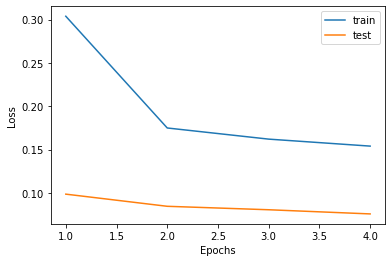

In [3]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [4]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:410]:INFO:starting testing in path: /data/LiftPose3D/fly_tether/cams_test/
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:58]:INFO:total params: 4.27M
[lift.py:66]:INFO:loading ckpt from '/data/LiftPose3D/fly_tether/cams_test/ckpt_best.pth.tar'
[lift.py:74]:INFO:ckpt loaded (epoch: 4 | err: 0.040159606127774326)
[lift.py:108]:INFO:Saving results: /data/LiftPose3D/fly_tether/cams_test/test_results.pth.tar


# Visualize Predictions

In [5]:
from liftpose.postprocess import load_test_results
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)

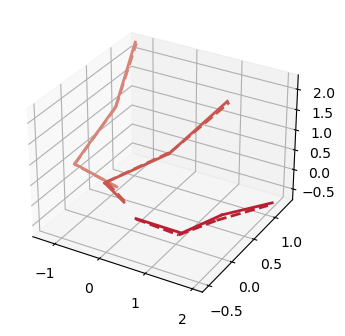

In [24]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')

t = 0
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=good_keypts[t])

In [25]:
test_3d_gt[100]-list(test_3d.values())[0][100]

array([[ 2.63129305e-08, -3.36579782e-08,  2.58093458e-06],
       [ 1.06751263e-07, -1.63140264e-08, -1.03906676e-06],
       [-8.36510088e-08, -6.37202944e-08, -4.23380726e-08],
       [ 5.57776554e-08,  3.95139159e-08, -8.35460469e-07],
       [-1.18496591e-07, -1.32446160e-08,  1.30798787e-06],
       [-2.16487042e-08,  3.10775961e-09,  2.75576437e-06],
       [ 1.42582279e-09, -6.97958267e-08, -2.78577961e-06],
       [ 3.83750078e-08,  4.00073059e-08, -1.82875633e-06],
       [-1.89490663e-08, -5.70331276e-08, -4.54392705e-07],
       [ 5.63110913e-08, -1.80284825e-08, -1.68770072e-06],
       [-2.76529279e-08,  1.50822672e-08, -8.69667389e-07],
       [-3.54132994e-08,  4.28356990e-08, -1.93447795e-06],
       [-4.86907799e-08,  3.28011192e-08, -2.85190578e-06],
       [-4.15977873e-08, -6.54424859e-08, -1.27220218e-06],
       [ 5.32774869e-09, -2.56111831e-08,  9.64347549e-07]])

In [12]:
list(test_3d.values())[0][0]

array([[  2.24919789,  -2.2721687 , 116.49212048],
       [  2.12497653,  -1.77896677, 116.45790967],
       [  3.10442051,  -1.76462453, 116.42904667],
       [  3.30408448,  -1.08723025, 116.20626915],
       [  3.83468654,  -0.46501442, 116.02653046],
       [  1.71076801,  -1.9972018 , 116.65502654],
       [  1.71872687,  -1.65075319, 116.59006016],
       [  1.86400875,  -2.15250043, 117.64774505],
       [  2.26355102,  -1.21726972, 117.53015945],
       [  2.82254118,  -0.49935566, 118.30018784],
       [  1.46847263,  -1.92349686, 116.70752803],
       [  1.41746143,  -1.52302353, 116.7416096 ],
       [  1.05787713,  -2.0207644 , 117.70512302],
       [  0.89355918,  -1.05138983, 118.1020087 ],
       [  0.59482198,  -0.35319519, 118.99063777]])

In [26]:
test_3d.keys()

dict_keys([(6, 'all', 'pose_result_fix__data_paper_180919_MDN_CsCh_Fly6_002_SG1_behData_images.cam_0'), (6, 'all', 'pose_result_fix__data_paper_180919_MDN_CsCh_Fly6_002_SG1_behData_images.cam_1'), (6, 'all', 'pose_result_fix__data_paper_180919_MDN_CsCh_Fly6_002_SG1_behData_images.cam_2'), (6, 'all', 'pose_result_fix__data_paper_180919_MDN_CsCh_Fly6_002_SG1_behData_images.cam_4'), (6, 'all', 'pose_result_fix__data_paper_180919_MDN_CsCh_Fly6_002_SG1_behData_images.cam_5'), (6, 'all', 'pose_result_fix__data_paper_180919_MDN_CsCh_Fly6_002_SG1_behData_images.cam_6'), (6, 'all', 'pose_result_fix__data_paper_180919_MDN_CsCh_Fly6_001_SG1_behData_images.cam_0'), (6, 'all', 'pose_result_fix__data_paper_180919_MDN_CsCh_Fly6_001_SG1_behData_images.cam_1'), (6, 'all', 'pose_result_fix__data_paper_180919_MDN_CsCh_Fly6_001_SG1_behData_images.cam_2'), (6, 'all', 'pose_result_fix__data_paper_180919_MDN_CsCh_Fly6_001_SG1_behData_images.cam_4'), (6, 'all', 'pose_result_fix__data_paper_180919_MDN_CsCh_Fly